In [0]:
# data_folder = './reuters21578/'
data_folder = ''

sgml_number_of_files = 22
sgml_file_name_template = 'reut2-NNN.sgm'

# Category files
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
}

# Word2Vec number of features
num_features = 500
# Limit each newsline to a fixed number of words
# document_max_num_words = 100
# Selected categories
# selected_categories = ['pl_usa']

In [0]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [0]:
# Create category dataframe

# Read all categories
category_data = []

for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0]])

# Create category dataframe
news_categories = pd.DataFrame(data=category_data)

# print "category_data: ", category_data
# (news_categories.values).tolist()

In [46]:
import re
import xml.sax.saxutils as saxutils
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def to_category_vector(categories):
    vector = zeros(len(categories)).astype(float32)
    
    for i in range(len(categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

In [0]:
lemmatizer = WordNetLemmatizer()
# strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
# stop_words = set(stopwords.words("english"))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleanUpSentence(r):#, stop_words = None#
#     r = r.lower().replace("<br />", " ")
    r = r.lower() # lowercase text
    r = REPLACE_BY_SPACE_RE.sub(' ', r)
    r = BAD_SYMBOLS_RE.sub('', r)
#     r = re.sub(strip_special_chars, "", r.lower())
    r = ' '.join(word for word in r.split() if word not in STOPWORDS)
#     if stop_words is not None:
    words = word_tokenize(r)
#         filtered_sentence = []
    for w in words:
        w = lemmatizer.lemmatize(w)
#             if w not in stop_words:
#                 filtered_sentence.append(w)
#         return " ".join(filtered_sentence)
#     else:
    return r

In [49]:
# Parse SGML files
document_X = {}
document_Y = {}
docid_traintest = {}
def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)

# Iterate all files
# for i in range(sgml_number_of_files):
#     if i < 10:
#         seq = '00' + str(i)
#     else:
#         seq = '0' + str(i)
        
#     file_name = sgml_file_name_template.replace('NNN', seq)
#     print('Reading file: %s' % file_name)
    #data_folder + file_name
with open(data_folder+'reut2-000.sgm', 'rb') as file:
    
    content = BeautifulSoup(file.read().lower(),'html.parser')

    for newsline in content('reuters'):
        document_categories = []

        # News-line Id
        document_id = newsline['newid']
#             print document_id,
        train_test = newsline['lewissplit']
        docid_traintest[document_id] = train_test
#             print "train_test: ",train_test

        # News-line text
        document_body = strip_tags(str(newsline('text')[0].body)).replace('reuter\n&#3;', '')
        doc_categories=strip_tags(str(newsline('topics')[0].body))
        doc_categories = unescape(doc_categories)

        document_body = unescape(document_body)

        # News-line categories
        topics = newsline.topics.contents
        places = newsline.places.contents
        people = newsline.people.contents
        orgs = newsline.orgs.contents
        exchanges = newsline.exchanges.contents

        for topic in topics:
            document_categories.append('to_' + strip_tags(str(topic)))

        for place in places:
            document_categories.append('pl_' + strip_tags(str(place)))

        for person in people:
            document_categories.append('pe_' + strip_tags(str(person)))

        for org in orgs:
            document_categories.append('or_' + strip_tags(str(org)))

        for exchange in exchanges:
            document_categories.append('ex_' + strip_tags(str(exchange)))
#             print "document_categories: ",document_categories
        # Create new document    
#             update_frequencies(document_categories)

        document_X[document_id] = document_body
        document_Y[document_id] = document_categories
# print(document_Y)
one_hot_label=[]
for key,v in document_Y.items():
    dict_temp={'Topics':0,'Places':0,'Peoples':0,'Exchanges':0,'Organizations':0}
    for i in v:
        string=i.split('_')
        category=string[0]
        if category=='to':
            dict_temp['Topics']+=1
        if category=='pl':
            dict_temp['Places']+=1
        if category=='ex':
            dict_temp['Exchanges']+=1
        if category=='or':
            dict_temp['Organizations']+=1
        if category=='pe':
            dict_temp['Peoples']+=1
    one_hot_label.append(dict_temp)
    
# print(one_hot_label)
ranking=[]
for i in one_hot_label:
    ranking.append(list(i.values()))
print(np.array(ranking).shape)
print(document_X)


(1000, 5)
{'1': 'showers continued throughout the week in\nthe bahia cocoa zone, alleviating the drought since early\njanuary and improving prospects for the coming temporao,\nalthough normal humidity levels have not been restored,\ncomissaria smith said in its weekly review.\n    the dry period means the temporao will be late this year.\n    arrivals for the week ended february 22 were 155,221 bags\nof 60 kilos making a cumulative total for the season of 5.93\nmln against 5.81 at the same stage last year. again it seems\nthat cocoa delivered earlier on consignment was included in the\narrivals figures.\n    comissaria smith said there is still some doubt as to how\nmuch old crop cocoa is still available as harvesting has\npractically come to an end. with total bahia crop estimates\naround 6.4 mln bags and sales standing at almost 6.2 mln there\nare a few hundred thousand bags still in the hands of farmers,\nmiddlemen, exporters and processors.\n    there are doubts as to how much of t

In [72]:
## rough
col_names = ['body', 'categories', 'word_count']
dataset = pd.DataFrame(columns = col_names)
print(dataset.head())

Empty DataFrame
Columns: [body, categories, word_count]
Index: []


In [0]:
# data preprocessing

In [80]:
totalX = []
#totalY = np.array(document_Y)
nltk.download('punkt')
nltk.download('wordnet')
#print(document_X.keys())
for i, doc in document_X.items():
    #print(i)
#     doc = doc.replace(r"\n", "\t")
#     totalX.append(cleanUpSentence(doc, stop_words))
      totalX.append(cleanUpSentence(doc))


# print(totalX[0])

##dataset
dataset['body'] = totalX
dataset['categories'] = ranking
dataset['word_count'] = dataset['body'].apply(lambda x: len(str(x).split(" ")))
print (dataset.head())
print (dataset.word_count.describe())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
                                                body       categories  \
0  showers continued throughout week bahia cocoa ...  [1, 3, 0, 0, 0]   
1  standard oil co bp north america inc said plan...  [0, 1, 0, 0, 0]   
2  texas commerce bancshares incs texas commerce ...  [0, 1, 0, 0, 0]   
3  bankamerica corp pressure act quickly proposed...  [0, 2, 0, 0, 0]   
4  us agriculture department reported farmerowned...  [6, 1, 0, 0, 0]   

   word_count  
0         356  
1          48  
2          35  
3         274  
4         122  
count    1000.000000
mean       85.346000
std        84.278937
min         1.000000
25%        38.000000
50%        59.000000
75%       103.250000
max       514.000000
Name: word_count, dtype: float64


In [81]:
print( totalX)

['showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february 22 155 221 bags 60 kilos making cumulative total season 593 mln 581 stage last year seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimates around 64 mln bags sales standing almost 62 mln hundred thousand bags still hands farmers middlemen exporters processors doubts much cocoa would fit export shippers experiencing dificulties obtaining +bahia superior+ certificates view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose 340 350 cruzados per arroba 15 kilos bean shippers reluctant offer nearby shipment limited sales

In [82]:
#Identify common words
freq = pd.Series(' '.join(dataset['body']).split()).value_counts()[:20]
freq

said       2508
mln        1288
dlrs       1103
reuter      924
pct         897
vs          750
000         682
billion     519
year        512
cts         487
would       418
us          406
new         380
company     373
last        321
net         305
inc         302
bank        294
1986        288
market      285
dtype: int64

In [83]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset ['body']).split()).value_counts()[-20:]
freq1

lehmand          1
lbs              1
hallgarten       1
necos            1
catapulted       1
centerior        1
anda             1
nepal            1
deirdre          1
1462             1
barnes           1
aiming           1
combat           1
conversations    1
umarl            1
twentyfive       1
to160            1
petroleos        1
depart           1
indefinite       1
dtype: int64

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

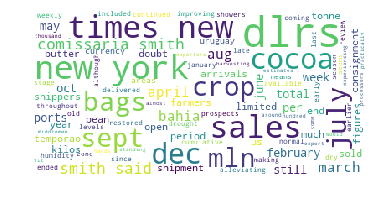

In [86]:
corpus = dataset.iloc[0]['body']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [15]:
max_vocab_size = 200
input_tokenizer = Tokenizer()# change accuracy....
input_tokenizer.fit_on_texts(totalX)
#print(input_tokenizer.word_counts)
encoded_docs = input_tokenizer.texts_to_matrix(totalX, mode='count')
print(encoded_docs.shape)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX)))
# print(input_tokenizer.word_counts)
# print(t.document_count)
# print(t.word_index)
# print(t.word_docs)
# print(totalX.counts)

(1000, 17601)
input_vocab_size: 17601


In [16]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
nn = Sequential()
nn.add(Dense(10, activation="relu", input_shape=(17601,)))
#nn.add(Flatten())
# nn.Flatten()
nn.add(Dense(5,activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
import math

def softmax(z):
    z_exp = [math.exp(i) for i in z]
    sum_z_exp = sum(z_exp)
    return [i / sum_z_exp for i in z_exp]

In [19]:
nn.fit(np.array(encoded_docs), np.array(ranking), batch_size=16, epochs=5,
          verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 1s 1ms/step - loss: 0.4448 - acc: 0.8264 - val_loss: 0.2347 - val_acc: 0.8660
Epoch 2/5
900/900 [==============================] - 0s 397us/step - loss: 0.1175 - acc: 0.8638 - val_loss: 0.0854 - val_acc: 0.8760
Epoch 3/5
900/900 [==============================] - 0s 383us/step - loss: -0.0857 - acc: 0.8731 - val_loss: -0.0145 - val_acc: 0.8780
Epoch 4/5
900/900 [==============================] - 0s 396us/step - loss: -0.2779 - acc: 0.8791 - val_loss: -0.0894 - val_acc: 0.8720
Epoch 5/5
900/900 [==============================] - 0s 384us/step - loss: -0.4310 - acc: 0.8840 - val_loss: -0.1334 - val_acc: 0.8700
